## The problem

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

## The Data
https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

In [14]:
from datetime import datetime

In [3]:
#Read the data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
features=pd.read_csv('features.csv')
stores=pd.read_csv('stores.csv')

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
test.tail()

,Store,Dept,Date,IsHoliday
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False
115063,45,98,2013-07-26,False


We will begin by working with statistical models/methods utilizing only the training data. Once we have the results on the validation set, we can compare other more sophisticated models that make use of other fetures as well.

# Exploratory data Analysis

In [8]:
dataset=train.merge(stores,how='left').merge(features,how='left')
test_dataset=test.merge(stores,how='left').merge(features,how='left')

In [9]:
dataset.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
5,1,1,2010-03-12,21043.39,False,A,151315,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106
6,1,1,2010-03-19,22136.64,False,A,151315,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106
7,1,1,2010-03-26,26229.21,False,A,151315,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106
8,1,1,2010-04-02,57258.43,False,A,151315,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808
9,1,1,2010-04-09,42960.91,False,A,151315,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808


In [10]:
dataset.shape

(421570, 16)

In [11]:
dataset.describe(include='all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
unique,NaN,NaN,143,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-12-23,NaN,False,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3027,NaN,391909,215478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,NaN,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,NaN,22711.183519,NaN,NaN,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,NaN,-4988.940000,NaN,NaN,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,NaN,2079.650000,NaN,NaN,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,NaN,7612.030000,NaN,NaN,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,NaN,20205.852500,NaN,NaN,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000


In [12]:
dataset.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [16]:

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [18]:
dataset['Date']=pd.to_datetime(dataset['Date'],dayfirst=True)

In [19]:
dataset['Year']=dataset['Date'].dt.year

In [20]:
dataset['Month']=dataset['Date'].dt.month
dataset['Week']=dataset['Date'].dt.isocalendar().week

In [66]:
dataset.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,2012,9,39
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,2012,10,40
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,2012,10,41
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,2012,10,42
421569,45,98,2012-10-26,1076.80,False,B,118221,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,2012,10,43


In [22]:
weekly_sales_2010=dataset[dataset['Year']==2010].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2011=dataset[dataset['Year']==2011].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2012=dataset[dataset['Year']==2012].groupby('Week')['Weekly_Sales'].mean()

In [23]:
weekly_sales_2010.tail()

Week
48    16924.051502
49    18882.893619
50    20892.463619
51    27378.692693
52    13738.538566
Name: Weekly_Sales, dtype: float64

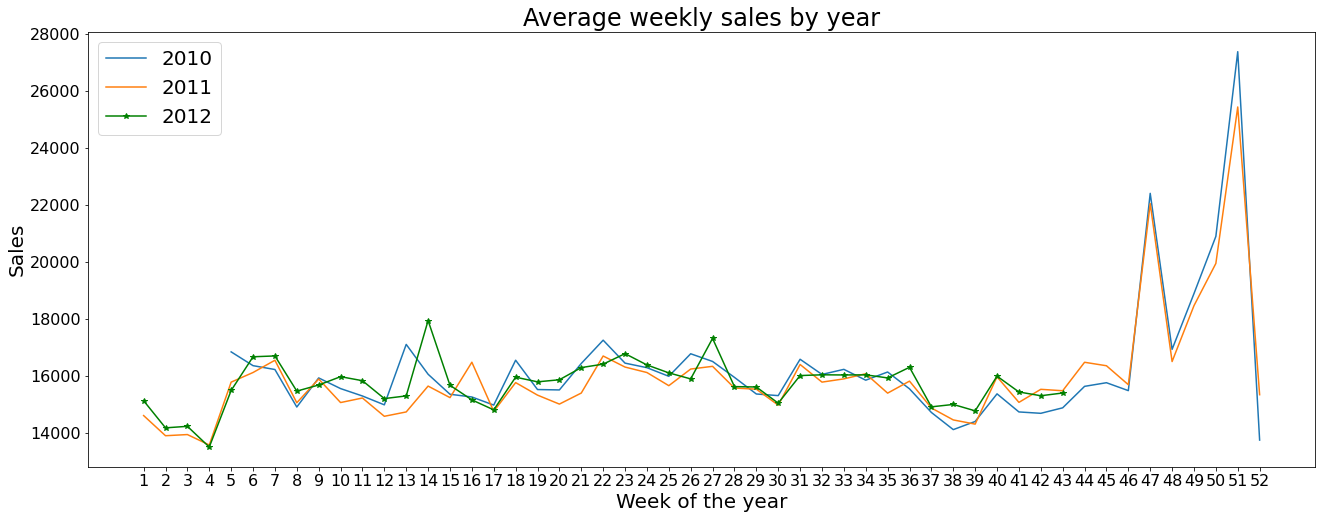

In [26]:
plt.figure(figsize=(22,8))
plt.plot(weekly_sales_2010.index,weekly_sales_2010.values)
plt.plot(weekly_sales_2011.index,weekly_sales_2011.values)
plt.plot(weekly_sales_2012.index,weekly_sales_2012.values,'-*g')

plt.xticks(np.arange(1,53,step=1),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Week of the year',fontsize=20)
plt.ylabel('Sales',fontsize=20)

plt.title('Average weekly sales by year',fontsize=24)
plt.legend(['2010','2011','2012'],fontsize=20)

In [46]:
new=pd.DataFrame(dataset.groupby('Store')['Weekly_Sales'].mean())

In [47]:
new.head()

,Weekly_Sales
Store,
1,21710.543621
2,26898.070031
3,6373.033983
4,29161.210415
5,5053.415813


In [50]:
#which store has the max
new.loc[new['Weekly_Sales']==max(new['Weekly_Sales'])]

,Weekly_Sales
Store,
20,29508.301592


In [52]:
holiday = {6:"Super Bowl", 36:"Labor day", 47:"Thanksgiving", 51:"Christmas"}

#sales average by holiday
holidays = dataset[dataset["Week"].isin([6,36,47,51])]
holidays.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,6
31,1,1,2010-09-10,18194.74,True,A,151315,78.69,2.565,NaN,NaN,NaN,NaN,NaN,211.495190,7.787,2010,9,36
42,1,1,2010-11-26,18820.29,True,A,151315,64.52,2.735,NaN,NaN,NaN,NaN,NaN,211.748433,7.838,2010,11,47
46,1,1,2010-12-24,55931.23,False,A,151315,52.33,2.886,NaN,NaN,NaN,NaN,NaN,211.405122,7.838,2010,12,51
53,1,1,2011-02-11,37887.17,True,A,151315,36.39,3.022,NaN,NaN,NaN,NaN,NaN,212.936705,7.742,2011,2,6


In [53]:
holiday_mean = holidays[["Weekly_Sales", "Week"]].groupby("Week").mean().reset_index().sort_values('Weekly_Sales', ascending=False)
holiday_mean = holiday_mean.rename(columns={"Week":"Holiday"})
holiday_mean["Holiday"] = holiday_mean["Holiday"].map(holiday)
holiday_mean

,Holiday,Weekly_Sales
3,Christmas,26396.399283
2,Thanksgiving,22220.944538
0,Super Bowl,16377.996441
1,Labor day,15881.693339


In [68]:
#check the NAN percentage
dataset.isna().mean()*100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Type             0.000000
Size             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Year             0.000000
Month            0.000000
Week             0.000000
dtype: float64

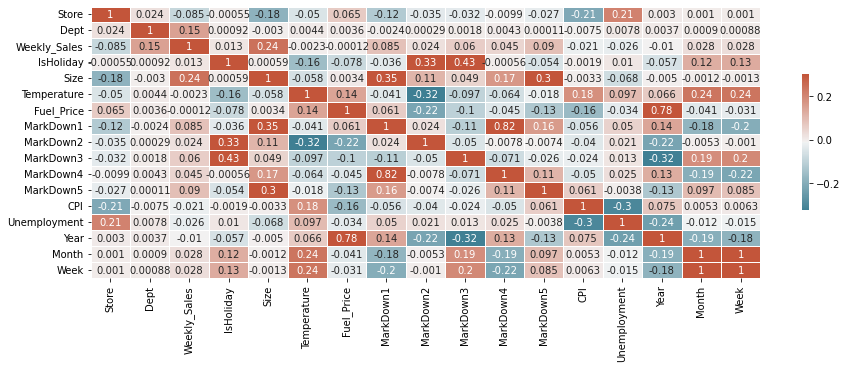

In [73]:
corr=dataset.corr()
f,ax=plt.subplots(figsize=(15,5))
cmap=sns.diverging_palette(220,20,as_cmap=True)
sns.heatmap(corr,cmap=cmap,vmax=.3,annot=True,linewidths=.5,cbar_kws={'shrink':.5})
plt.show()

Weekly sales (dependent variable) has a higher correlation with Department,Store Size and Store.

## Data Manipulation

In [74]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

We will remove null values and the variables with lower correlation. Create variables for year, month and week.

In [76]:
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]=dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)

In [78]:
dataset['Year']=pd.to_datetime(dataset['Date']).dt.year
dataset['Month']=pd.to_datetime(dataset['Date']).dt.month
dataset['Week']=pd.to_datetime(dataset['Date']).dt.isocalendar().week
dataset=dataset.drop(columns=['Date','CPI','Fuel_Price','Unemployment','Temperature'])


In [79]:
dataset.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year,Month,Week
0,1,1,24924.50,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,5
1,1,1,46039.49,True,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,6
2,1,1,41595.55,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,7
3,1,1,19403.54,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,8
4,1,1,21827.90,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,3,9


In [80]:
df=dataset.pop('Weekly_Sales')
dataset['Weekly_Sales']=df

In [81]:
#Identify input and target columns
input_cols,target_cols=dataset.columns[:-1],dataset.columns[-1]
input_df,targets=dataset[input_cols].copy(),dataset[target_cols].copy()

In [82]:
numeric_cols=dataset[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols=dataset[input_cols].select_dtypes(include='object').columns.tolist()

In [83]:
#Imputation for the numeric columns
imputer=SimpleImputer().fit(input_df[numeric_cols])
input_df[numeric_cols]=imputer.transform(input_df[numeric_cols])

In [84]:
scaler=MinMaxScaler().fit(input_df[numeric_cols])
input_df[numeric_cols]=scaler.transform(input_df[numeric_cols])

In [86]:
#For categorical columns
encoder=OneHotEncoder(sparse=False,handle_unknown='ignore').fit(input_df[categorical_cols])
encoded_cols=list(encoder.get_feature_names_out(categorical_cols))
input_df[encoded_cols]=encoder.transform(input_df[categorical_cols])

C:\Users\uzmam\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Models

In [88]:
X_train,X_test,y_train,y_test=train_test_split(input_df[numeric_cols+encoded_cols],targets,test_size=0.25,random_state=42)

In [89]:
X_train.head()

,Store,Dept,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year,Month,Week,Type_A,Type_B,Type_C
150504,0.340909,0.183673,0.120825,0.005471,0.002538,0.003563,0.000240,0.008854,0.5,1.000000,0.980392,0.0,1.0,0.0
216043,0.477273,0.928571,0.458367,0.000000,0.002536,0.000205,0.000000,0.000000,0.5,0.454545,0.411765,0.0,1.0,0.0
295382,0.681818,0.112245,0.914088,0.191174,0.038701,0.000793,0.165807,0.076634,1.0,0.090909,0.098039,1.0,0.0,0.0
279744,0.636364,0.204082,0.318073,0.000000,0.002536,0.000205,0.000000,0.000000,0.0,0.545455,0.490196,0.0,1.0,0.0
377848,0.886364,0.591837,0.650663,0.000000,0.002536,0.000205,0.000000,0.000000,0.5,0.272727,0.313725,1.0,0.0,0.0


In [91]:
import xgboost
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import warnings
warnings.simplefilter(action='ignore')

In [92]:
from sklearn.metrics import mean_absolute_error

# Function to evaluate model by using accuracy measures

def evaluate_model(y_test, y_pred, method):
    if method =='mae':
        score= mean_absolute_error(y_test, y_pred)
    else: 
        print("Only available acuuracy measures is mae.")
    return score

In [93]:
#Function to build model
def train_model(X_train, X_test, y_train, y_test):
    model_dict = {
        'linear_reg': LinearRegression,
        'elastic_net': ElasticNet,
        'ridge_reg' : Ridge,
        'lasso_reg' : Lasso,
        'xgb_reg' : xgboost.XGBRegressor,
        'adaboost_reg' : AdaBoostRegressor,
        'gb_reg' : GradientBoostingRegressor,
        'tree_reg' : DecisionTreeRegressor,
        'forest_reg' : RandomForestRegressor
    }

    fitted_model=[]
    mae=[]
    
    for model_name in list(model_dict.keys()):   
        model = model_dict[model_name]()
        fitted_model.append(model.fit(X_train, y_train))
        mae.append(evaluate_model(y_test, model.predict(X_test), 'mae'))
            
    min_test = min_val_index(mae)
    min_mae = min_test[0]
    min_mae_index = min_test[1]
    final_model = fitted_model[min_mae_index]
    return (final_model, min_mae)

In [95]:
# Function to find minimum value and returning minimum value and its index
def min_val_index(l):
    min_l = min(l)
    min_index = l.index(min_l)
    return (min_l, min_index)

In [96]:
# Train the models
test = train_model(X_train,X_test,y_train,y_test)
best_model = test[0]
mae_val = test[1]

In [97]:
print('Best model is',best_model,'MAE=',mae_val)

Best model is RandomForestRegressor() MAE= 1420.4162359957493


In [98]:
print(test)

(RandomForestRegressor(), 1420.4162359957493)
